# Проект "Оценка результатов A/B-теста по изменению уровня размещения "врат" в игре Cookie Cats"

**Описание исследования:**
Cookie Cats -  популярная мобильная игра-головоломка, в стиле "соедини три", в которой игрок должен соединить плитки одного цвета, чтобы очистить игровое поле и выиграть уровень.

По мере прохождения уровней игры игроки периодически сталкиваются с так называемыми "вратами", которые заставляют их ждать некоторое количество времени или совершать покупку в приложении, чтобы продвинуться дальше. Помимо стимулирования покупок в приложении, эти врата предоставляют игрокам вынужденный перерыв в игре, чтобы предотвратить "усталось игроков от игры".

Изначально первые врата были размещены на 30-м уровне.
Но разработчик принял решение провести AB-тест, в тестовой группе которого первые врата перемещены с 30-го на 40-й уровень.

Необходимо пранализировать влияние данного изменения на удержание пользователей.

**Данные:**
информация об активности 90 189 игроков, которые установили игру во время выполнения AB-теста.

Структура данных:
* userid - Уникальный номер, идентифицирующий каждого игрока.
* version - версия расположения врат(группа тестирования).
* sum_gamerounds - количество игровых раундов, сыгранных игроком в течение первых 14 дней после установки.
* retention_1 - вернулся ли игрок и играл ли он через 1 день после установки?
* retention_1 - вернулся ли игрок и играл ли он через 7 дней после установки?

**Используемые инструменты:** Python (pandas (работа с пропусками, типами данных, объединение таблиц, группировка), numpy (применение статического критерия), seaborn, matplotlib (визуалиция данных: построение воронки продаж)),

**Результат:** 
Анализ результатов А/В - теста показал, что удержание пользователей на седьмой день после загрузки в контрольной группе("врата" на 30 уровне) выше, чем в тестовой группе("врата" на 40 уровне), что подтверждено статистически. Статистически значимых различий в удержании пользователей через 1 день после загрузки игры не выявлено.

Однако есть основания предположить, что на удержание пользователей могли оказать прочие факторы и распределение пользователей между исследуемыми группами проведено не совсем корректно проведено, так как аналогичные результаты показала проверка гиппотез на выборке пользователей, прошедших менее 30 уровней игры, на которых влияние исследуемого фактора не оказывалось.


## Загрузка и ознакомление с данными. 

In [1]:
# импортируемые необходимые библиотеки
import pandas as pd
import numpy as np

from ydata_profiling import ProfileReport
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Загрузим данные и изучим основную информацию о них.

In [2]:
data = pd.read_csv("...")

**Вариант 1**

Изучим датасет при помощи библиотеки data-profiling.

In [3]:
ProfileReport(data) 

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Вариант 2**

Воспользуемся функцией для изучения общей информации о каждом из столбцов фрейма.

In [4]:
def inform (data, dict_1 = None):
    '''Данная функция принимает в качестве аргумента датафрейм и выводит основную информацию о каждом из его столбцов:
    * наименование столбца, его описание на русском языке(в случае, если вторым аргументом в функцию передан 
    словарь содержащий необходимую информацию);
    * тип данных;
    * информацию о наличии пропусков и выбросов.
    '''
    if dict_1 == None:
        dict_1 = {}
    print(f'Количество строк в датафрейме: {data.shape[0]}\n\nИнформация о столбцах датафрейма:\n')
    n = 1
    for column in data.columns:
        print(n,')',sep = '', end = ' ')
        try:
            print(f'Столбец "{column}" - {dict_1[column]}:')
        except:
            print(f'Столбец "{column}":')
        print(f'Тип данных: {data[column].dtype}')
        print(f'Количество уникальных значений: {data[column].nunique()}.')
        if data[column].isna().sum() == 0:
            print('Пропуски отсутствуют.')
        else: 
            print(f'Количество пропусков в столбце: {data[column].isna().sum()} ({data[column].isna().sum()/len(data):.2%}).')
        try:
            q1,q3 = data[column].quantile(0.25), data[column].quantile(0.75)
            iqr = q3 - q1
            data1 = data.loc[(data[column] < (q3 + 1.5*iqr)) & (data[column] > (q1 - 1.5*iqr))]
            length = len(data1)+data[column].isna().sum()
            if length == len(data):
                print('Выбросы отсутствуют.')
            else:
                print(f'Количество выбросов в столбце: {len(data) - length} ({(len(data) - length)/len(data):.2%}).')
        except:
            pass
        print('-'*45)
        n+=1

In [5]:
inform(data)

Количество строк в датафрейме: 90189

Информация о столбцах датафрейма:

1) Столбец "userid":
Тип данных: int64
Количество уникальных значений: 90189.
Пропуски отсутствуют.
Выбросы отсутствуют.
---------------------------------------------
2) Столбец "version":
Тип данных: object
Количество уникальных значений: 2.
Пропуски отсутствуют.
---------------------------------------------
3) Столбец "sum_gamerounds":
Тип данных: int64
Количество уникальных значений: 942.
Пропуски отсутствуют.
Количество выбросов в столбце: 10276 (11.39%).
---------------------------------------------
4) Столбец "retention_1":
Тип данных: bool
Количество уникальных значений: 2.
Пропуски отсутствуют.
---------------------------------------------
5) Столбец "retention_7":
Тип данных: bool
Количество уникальных значений: 2.
Пропуски отсутствуют.
---------------------------------------------


Датафрейм состоит из 90189 строк. Количество уникальных значений в столбце с ID пользователей(90189) свидетельствует о том, что дубликаты в данных, а также пользователи, попавшие в обе из исследуемых групп отсутствуют. 
Пропуски в данных отсутствуют. Тип данных в столбцах соответствует.

Переименуем столбец с ID пользователей.

In [6]:
data.rename(columns={'userid': 'user_id'}, inplace=True)

## Исследование данных

### Изучение распределения пользователей между группами

Объявим функцию, исследующую корректность распределения пользователей между группами.

In [7]:
def separate_info(data):
    '''Данная функция принимает в качестве аргумента датафрейм и выводит общее количество пользователей датафрейме,
    количество пользователей в каждой из групп и относительную разницу в количестве пользователей между группами.
    '''
    group_a = data.query('version == "gate_30"')
    group_b = data.query('version == "gate_40"')
    print(f'Количество пользователей в целом: {data.user_id.nunique()}',
          f'Количество пользователей  в группе "gate_30": {group_a.user_id.nunique()}',
          f'Количество пользователей  в группе "gate_40": {group_b.user_id.nunique()}',
          f'Относительная разница в размерах групп: {(group_a.user_id.nunique()-group_b.user_id.nunique())/group_b.user_id.nunique()}'
          , sep = '\n')

Изучим распределение пользователей между группами.

In [8]:
separate_info(data)

Количество пользователей в целом: 90189
Количество пользователей  в группе "gate_30": 44700
Количество пользователей  в группе "gate_40": 45489
Относительная разница в размерах групп: -0.01734485260172789


В целом, пользователи распределены между группами равномерно.

### Изучение удержания пользователей

Проверим наличие пользователей, не заходивших в приложение через 1 день после загрузки игры, но заходивших через 7 дней.

In [9]:
data.query('not retention_1 and retention_7')

,user_id,version,sum_gamerounds,retention_1,retention_7
10,1842,gate_40,3,False,True
23,2729,gate_30,105,False,True
90,8788,gate_30,19,False,True
102,10200,gate_40,106,False,True
143,13429,gate_30,60,False,True
...,...,...,...,...,...
89967,9975174,gate_30,26,False,True
90044,9982773,gate_30,1,False,True
90046,9983040,gate_30,137,False,True
90156,9996093,gate_40,23,False,True


В данных имеются практически 3600 таких пользователей.  
В этом случае рассчитывается классическое удержание пользователей.
В случае рассчета скользящего удержания, для данных пользователей необходимо было бы установить значение истины в столбце "retention_1".

Уточним удержание пользователей через один день и через семь дней после загрузки игры.

In [10]:
data.groupby('version').agg({'retention_1':'mean',	'retention_7':'mean'})

,retention_1,retention_7
version,,
gate_30,0.448188,0.190201
gate_40,0.442283,0.182000


**Вывод:** В целом, удержание пользователей в контрольной группе выше, чем в тестовой как через 1 день, так и через 7 дней после загрузки игры.

### Изучение количества уровней, пройденных пользователями

Так как в столбце с количеством пройденных уровней имеется большое количество выбросов, перед проведением анализа необходимо исследовать его дополнительно.

Рассмотрим данные описательной статистики.

In [11]:
data['sum_gamerounds'].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

Ввиду большого количества выбросов в столбце, медиана и среднее значение существенно различаются.

Дополнительно определим значение 99 квантиля распределения значений в столбце.

In [12]:
data['sum_gamerounds'].quantile(.99)

493.0

99 % пользователей, представленных в данных прошли менее 500 уровней игры.

Построим гистограмму распределения количества уровней, пройденных пользователями, с ограничением диапазона значений.

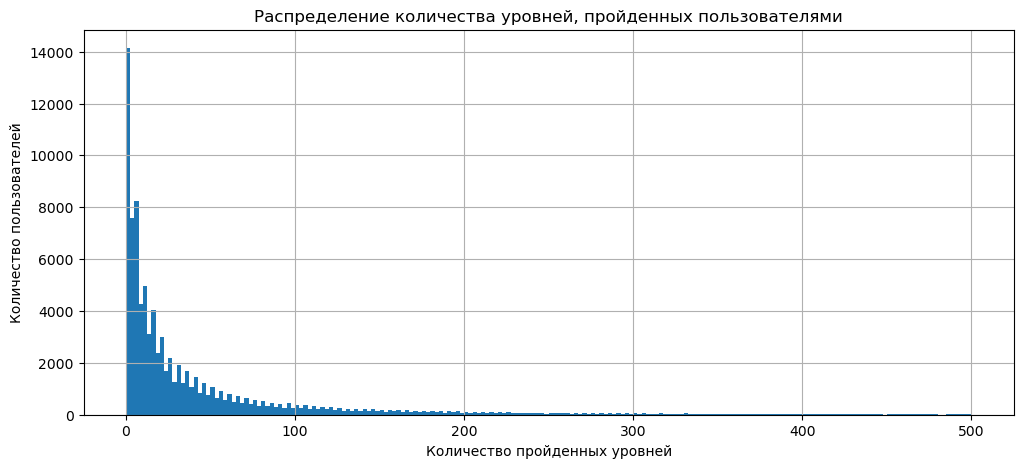

In [13]:
plt.figure(figsize=(12, 5))
data['sum_gamerounds'].hist(bins = 200, range = (0, 500))
plt.title('Распределение количества уровней, пройденных пользователями')
plt.xlabel('Количество пройденных уровней')
plt.ylabel('Количество пользователей');

Дополнительно построим диаграммы рассеивания (общую и с ограничением по количеству пройденных уровней).

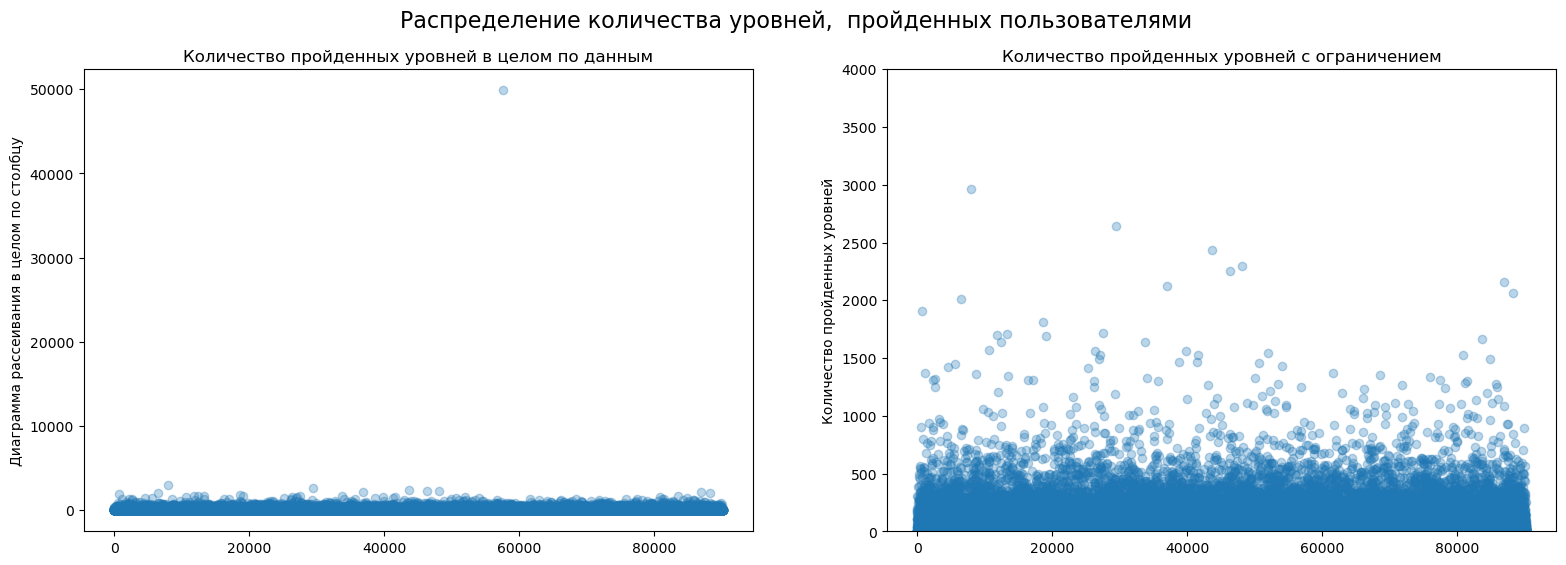

In [14]:
x_values = pd.Series(range(0, len(data)))

plt.figure(figsize=(19,6))
plt.suptitle('Распределение количества уровней,  пройденных пользователями',  fontsize=16)

plt.subplot(1,2,1)
plt.scatter(x_values, data['sum_gamerounds'], alpha = 0.3)
plt.title(f'Количество пройденных уровней в целом по данным')
plt.ylabel('Диаграмма рассеивания в целом по столбцу')

plt.subplot(1,2,2)
plt.scatter(x_values, data['sum_gamerounds'], alpha = 0.3)
plt.title('Количество пройденных уровней с ограничением')
plt.ylabel('Количество пройденных уровней')
plt.ylim(0,4000);

А также диаграммы размаха в группировке по версиям.

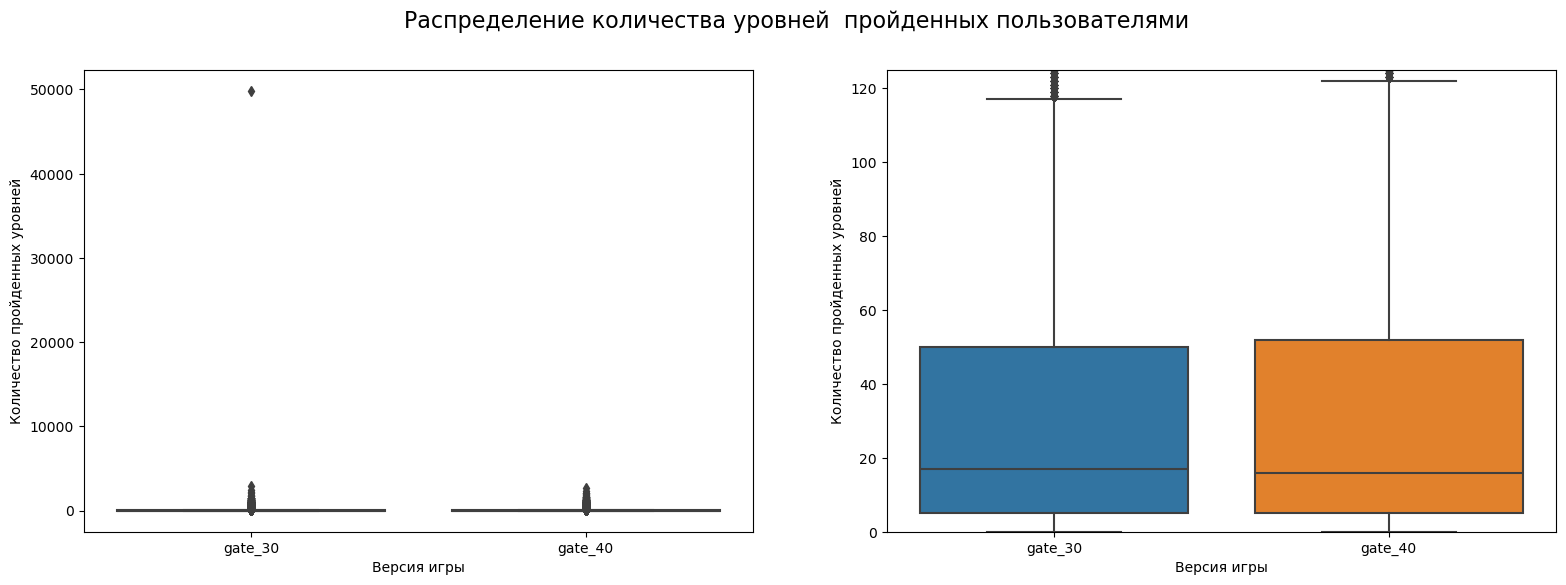

In [15]:
plt.figure(figsize=(19,6))
plt.suptitle('Распределение количества уровней  пройденных пользователями',  fontsize=16)

plt.subplot(1,2,1)
sns.boxplot(y ='sum_gamerounds', x = 'version', data = data )
plt.ylabel('Количество пройденных уровней')
plt.xlabel('Версия игры')

plt.subplot(1,2,2)
sns.boxplot(y ='sum_gamerounds', x = 'version', data = data)
plt.ylabel('Количество пройденных уровней')
plt.xlabel('Версия игры')
plt.ylim(0,125)
plt.show();

Также выведем 15 строк с наибольшими значениями в столбце.

In [16]:
data.nlargest(15, 'sum_gamerounds')

,user_id,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True
7912,871500,gate_30,2961,True,True
29417,3271615,gate_40,2640,True,False
43671,4832608,gate_30,2438,True,True
48188,5346171,gate_40,2294,True,True
46344,5133952,gate_30,2251,True,True
87007,9640085,gate_30,2156,True,True
36933,4090246,gate_40,2124,True,True
88328,9791599,gate_40,2063,True,True
6536,725080,gate_40,2015,True,True


Только 10 пользователей прошли больше 2000 уровней. При этом один из пользователей, попавших в контрольную группу, прошел около 50 тысяч уровней за 14 дней. Это является откровенной аномалией, так как такого результата можно достичь только с средней скоростью проходения 2,5 уровня в минуту(150 уровней в час), без перерывов на сон и отдых. 

В границах нормального распределения находятся пользователи, прошедшие чуть более 120 уровней за 14 дней. При этом выбросов в столбце более 10000(более 11%). 

Так как основная задача исследования - выявить влияние изменения на удержание пользователей, удалим из данных только строку с аномально большим значеним в количестве пройденных уровней.

In [17]:
data = data[data['sum_gamerounds'] < 3000]

Количество уровней, прошедших пользователями за 14 дней, особенно на малых значениях, можно рассматривать также как уровень, с которого пользователь  перешел из разряда действующих в разряд отточных. 

Оценим распределение количества пройденных уровней по каждой из групп, ограничив количество пройденных уровней границами нормального распределения.

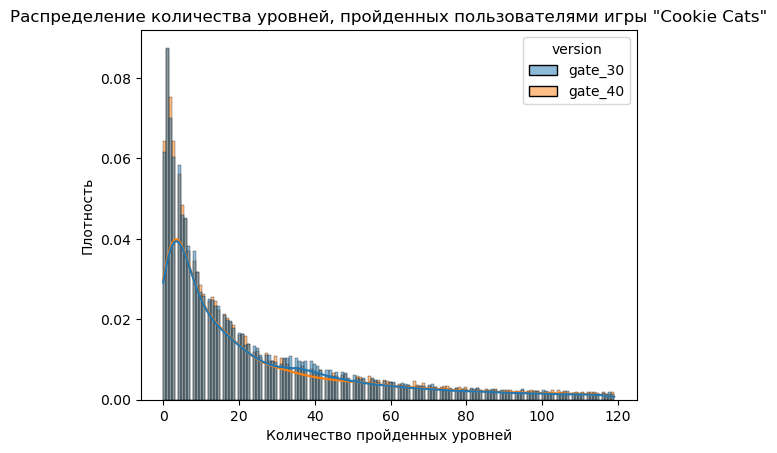

In [18]:
sns.histplot(data=data.query('sum_gamerounds < 120'), x="sum_gamerounds", hue='version', bins=150, stat='density', common_norm=False, kde=True)
plt.title(f'Распределение количества уровней, пройденных пользователями игры "Cookie Cats"')
plt.xlabel('Количество пройденных уровней')
plt.ylabel('Плотность')
plt.show()

Уточним график, ограничив диапазон по осям.

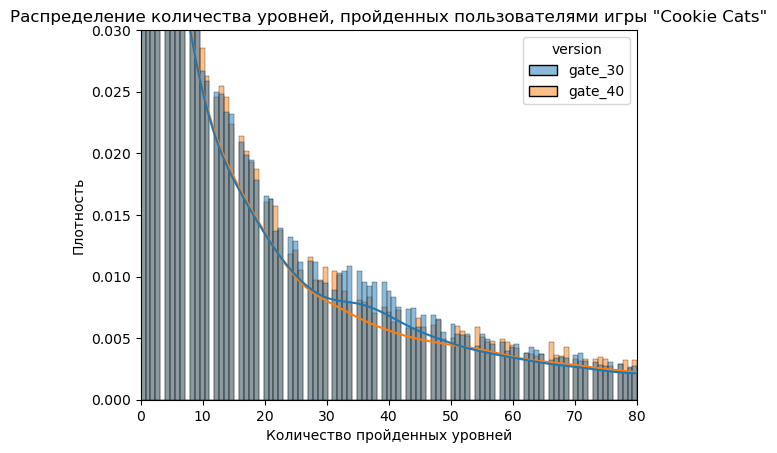

In [19]:
sns.histplot(data=data.query('sum_gamerounds < 120'), x="sum_gamerounds", hue='version', bins=150, stat='density', common_norm=False, kde=True)
plt.title(f'Распределение количества уровней, пройденных пользователями игры "Cookie Cats"')
plt.xlabel('Количество пройденных уровней')
plt.ylabel('Плотность')
plt.ylim(0,0.03)
plt.xlim(0,80)
plt.show()

**Вывод:** В целом распределение количества уровней, пройденных пользователями контрольной и исследуемых групп кардинально не отличаются. 

Однако, обращает на себя внимание разница между группами на интервале от 30 до 50 пройденных уровней. Что может свидетельствовать, что появление "врат" стимулирует отток пользователей.

В таком случае, проводить анализ влияния исследуемого фактора на среднее количество пройденных уровней может быть не совсем корректно, так как время появления исследуемого фактора может влиять на среднее количество пройденных уровней.

### Формирование исследуемых выборок

Задачей исследования является анализ влияния на удержание пользователей времени возникновения "врат" с 30 уровня(в контрольной группе) на 40(в тестовой).
Однако в данных имеется некоторое количество пользователей, прошедших менее 30 уровней, т.е. абсолютно не ощутивших на себе влияние исследуемого фактора.

In [20]:
print(f'Доля пользователей, прошедших менее 30 уровней: {data[data["sum_gamerounds"] < 30].shape[0]/data.shape[0]:.0%}')

Доля пользователей, прошедших менее 30 уровней: 63%


Таких пользователей более 63%.
В теории данные пользователи являются элементами одной совокупности и ощутили одинаковое влияние факторов.   
В случае корректного распределения пользователей между группами, статистически значимые различия между нимы не должны быть выявлены. 

Помимо исходных данных оценим две выборки:
* пользователей, прошедших 30 и более уровней(подвергшихся влиянию исследуемого фактора);
* пользователей, прошедших менее 30 уровней(как пользователей, не ощутивших влияние исследуемого фактора.

In [21]:
data_30 = data.query('sum_gamerounds >= 30')
data_not30 = data.query('sum_gamerounds < 30')

Проверим выборки на корректность распределения пользователей.

In [22]:
separate_info(data)

Количество пользователей в целом: 90188
Количество пользователей  в группе "gate_30": 44699
Количество пользователей  в группе "gate_40": 45489
Относительная разница в размерах групп: -0.017366835938358725


In [23]:
separate_info(data_30)

Количество пользователей в целом: 33268
Количество пользователей  в группе "gate_30": 16655
Количество пользователей  в группе "gate_40": 16613
Относительная разница в размерах групп: 0.0025281406127731294


In [24]:
separate_info(data_not30)

Количество пользователей в целом: 56920
Количество пользователей  в группе "gate_30": 28044
Количество пользователей  в группе "gate_40": 28876
Относительная разница в размерах групп: -0.02881285496606178


В целом, количественное распределение пользователей между группами по всем выборкам произведено корректно.

## Анализ результатов АB-теста

### Анализ удержания пользователей

#### Визуализация удержания пользователей через 1 день и через 7 дней после загрузки игры

Визуализируем удержание пользователей через 1 день и через 7 дней после загрузки игры, в группировке по версиям.  
Для этого объявим соответствующую функцию.

In [25]:
def retention_visual(data):
    '''Данная функция принимает в качестве аргумента датафрейм, группирует его по версиям, вычисляет среднее 
    значение удержания через один день и через семь дней после загрузки игры в каждой из групп, и визуализирует полученный результат.
    '''
    retention = data.groupby('version').agg({'retention_1':'mean', 'retention_7': 'mean'}).reset_index()
    
    plt.figure(figsize=(19,6))
    plt.suptitle('Распределение количества пройденных уровней по пользователям',  fontsize=16)
    
    plt.subplot(1,2,1)
    ax = sns.barplot(data=retention, x='version', y='retention_1')
    plt.bar_label(ax.containers[0], size=11, label_type='edge')
    plt.title(f'Удержание через 1 день после загрузки')
    plt.xlabel('Версия игры')
    plt.ylabel(f'Доля пользователей')
    
    plt.subplot(1,2,2)
    ax = sns.barplot(data=retention, x='version', y='retention_7')
    plt.bar_label(ax.containers[0], size=11, label_type='edge')
    plt.title(f'Удержание через 7 дней после загрузки')
    plt.xlabel('Версия игры')
    plt.ylabel(f'Доля пользователей')
    plt.show();

##### Визуализация удержания на исходных данных.

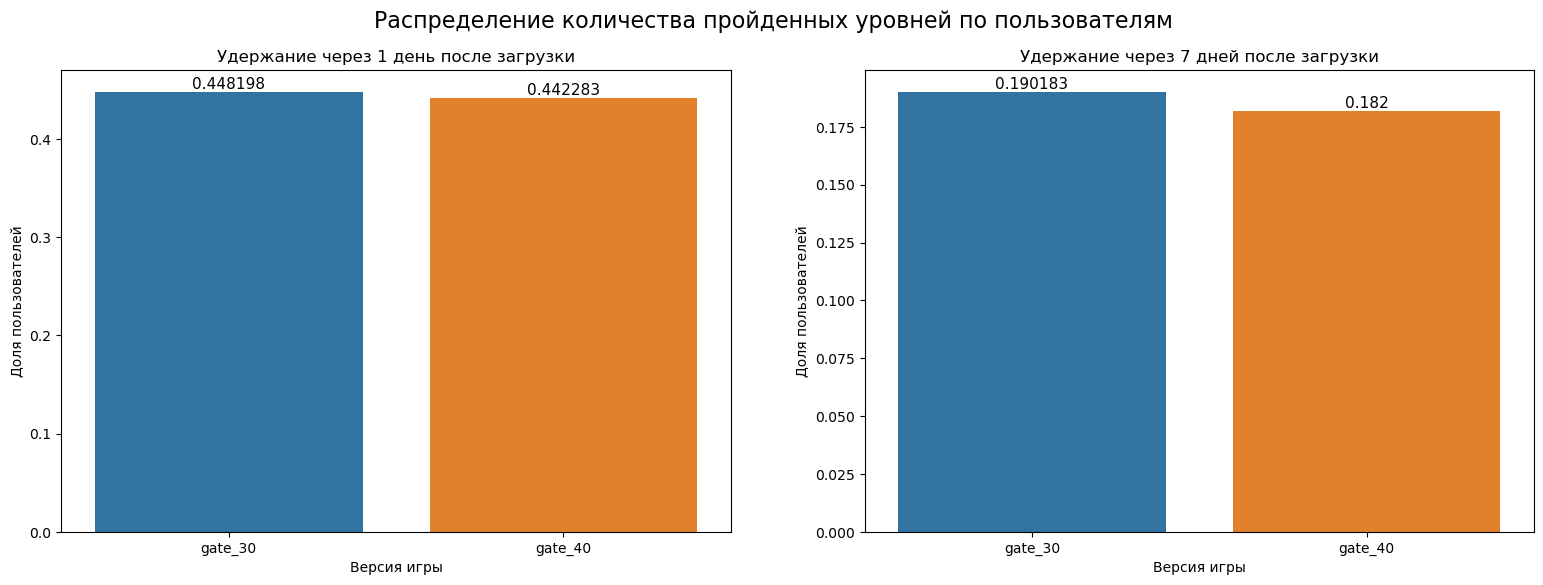

In [26]:
retention_visual(data)

**Вывод:** В целом по данным среднее удержание пользователей в контрольной группе выше, чем в тестовой, как через день, так и через семь дней после загрузки.

##### Визуализация удержания по выборке пользователей, прошедших 30 и более уровней

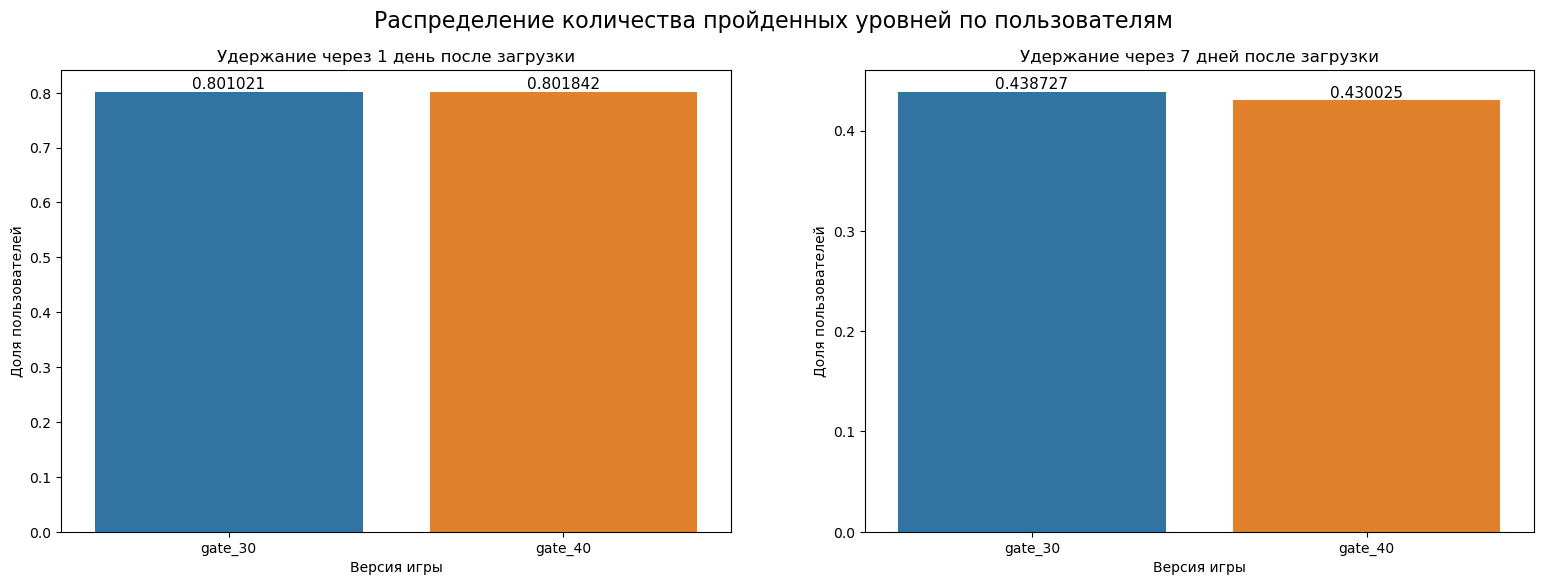

In [27]:
retention_visual(data_30)

**Вывод:** В выборке пользователей, прошедших 30 и более уровней, удержание пользователей через один день после загрузки между группами существенно не различается.Через семь дней после загрузки удержание в контрольной группе незначительно выше, чем в тестовой.

##### Визуализация удержания по выборке пользователей, прошедших менее 30 уровней

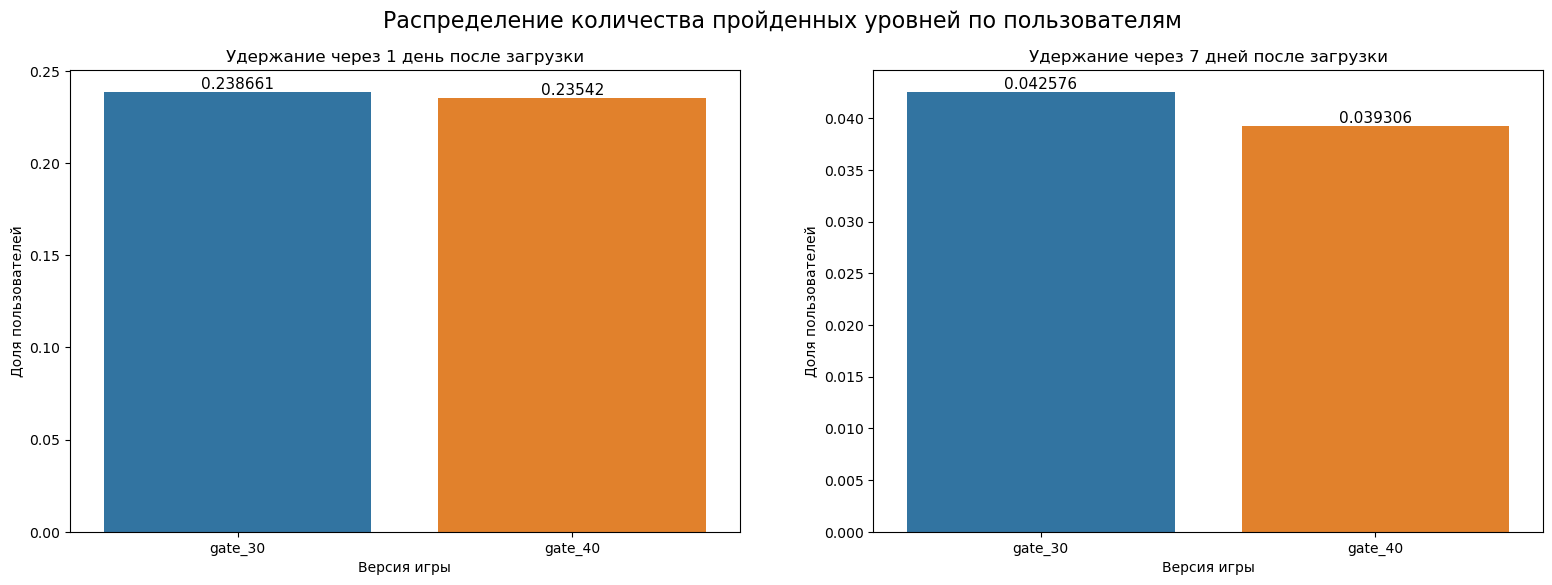

In [28]:
retention_visual(data_not30)

**Вывод:** В выборке пользователей, прошедшиx менее 30 уровней, удержание пользователей как через день, так и через семь дней после загрузки, в контрольной группе также выше, чем в тестовой.

##### Общий вывод:
В целом по всем трем выборкам и через день и через семь дней после загрузки игры, удержание в контрольной группе выше, чем удержание в тестовой. 

#### Проверка статистических гипотез

Результаты анализа данных об удержании пользователей не позволяют предполагать, что изменение времени появления фактора положительно сказалось на удержании пользователей.Удержание в контрольной группе по всем из исследуемых выборок выше, чем в тестовой.  
В данном случае проверим, есть ли статистически значимые различия между выборками. Проведем двусторонний тест. В качестве статистического критерия будем использовать Z-тест для пропорций. 

В рамках проверки результатов А/В проверим следующие гипотезы:
1. Гипотеза о равенстве среднего удержания через 1 день после загрузки игры.
2. Гипотеза о равенстве среднего удержания через 7 дней после загрузки игры.

Объявим функцию проверки указанных выше гипотез.

In [29]:
def statistic(data_s):
    '''Данная функция принимает в качестве аргумента датафрейм, формулирует нулевую и альтернативную гипотезы равенства
     среднего удержания между группами на черезодин и через сень дней после загрузки игры и проверяет их Z-тестом для пропорцийи.
    '''
    retention = data_s.groupby('version').agg({'retention_1':'sum', 'retention_7': 'sum', 'user_id': 'count'}).reset_index()
    n = 1
    names = {'retention_1': 'через 1 день после загрузки', 'retention_7': 'через 7 дней после загрузки'}
    for i in ['retention_1', 'retention_7']:
        print(f'{n}) ', end = ' ')
        print('Гипотезы:',
              f'H_0: Удержание пользователей в группе "gate_30" {names[i]} = Удержание пользователей в группе "gate_40" {names[i]}',
              f'H_1: Удержание пользователей в группе "gate_30" {names[i]} ≠ Удержание пользователей в группе "gate_40" {names[i]}',
              sep = '\n')
        alpha = 0.05 
        count = np.array([retention.query('version == "gate_30"')[i],
                          retention.query('version == "gate_40"')[i]])
        nobs = np.array([retention.query('version == "gate_30"')['user_id'],
                         retention.query('version == "gate_40"')['user_id']])
        stat, p_value = proportions_ztest(count, nobs)
        print(f'p_value: {float(p_value)}')
        if (p_value < alpha):
            print("Есть основания отвергнуть нулевую гипотезу: между долями есть значимая разница.")
        else:
            print("Оснований для отвержения нулевой гипотезы нет,  доли статистически не различаются.")
        n+=1   
        print()

##### Проверка гипотез на исходных данных

In [30]:
statistic(data)

1)  Гипотезы:
H_0: Удержание пользователей в группе "gate_30" через 1 день после загрузки = Удержание пользователей в группе "gate_40" через 1 день после загрузки
H_1: Удержание пользователей в группе "gate_30" через 1 день после загрузки ≠ Удержание пользователей в группе "gate_40" через 1 день после загрузки
p_value: 0.0739207603418346
Оснований для отвержения нулевой гипотезы нет,  доли статистически не различаются.

2)  Гипотезы:
H_0: Удержание пользователей в группе "gate_30" через 7 дней после загрузки = Удержание пользователей в группе "gate_40" через 7 дней после загрузки
H_1: Удержание пользователей в группе "gate_30" через 7 дней после загрузки ≠ Удержание пользователей в группе "gate_40" через 7 дней после загрузки
p_value: 0.0015917731773993442
Есть основания отвергнуть нулевую гипотезу: между долями есть значимая разница.



##### Проверка гипотез на выборке пользователей, прошедших 30 и более уровней

In [31]:
statistic(data_30)

1)  Гипотезы:
H_0: Удержание пользователей в группе "gate_30" через 1 день после загрузки = Удержание пользователей в группе "gate_40" через 1 день после загрузки
H_1: Удержание пользователей в группе "gate_30" через 1 день после загрузки ≠ Удержание пользователей в группе "gate_40" через 1 день после загрузки
p_value: 0.8510821961245407
Оснований для отвержения нулевой гипотезы нет,  доли статистически не различаются.

2)  Гипотезы:
H_0: Удержание пользователей в группе "gate_30" через 7 дней после загрузки = Удержание пользователей в группе "gate_40" через 7 дней после загрузки
H_1: Удержание пользователей в группе "gate_30" через 7 дней после загрузки ≠ Удержание пользователей в группе "gate_40" через 7 дней после загрузки
p_value: 0.10934855851569794
Оснований для отвержения нулевой гипотезы нет,  доли статистически не различаются.



##### Проверка гипотез на выборке пользователей, прошедших менее 30  уровней

In [32]:
statistic(data_not30)

1)  Гипотезы:
H_0: Удержание пользователей в группе "gate_30" через 1 день после загрузки = Удержание пользователей в группе "gate_40" через 1 день после загрузки
H_1: Удержание пользователей в группе "gate_30" через 1 день после загрузки ≠ Удержание пользователей в группе "gate_40" через 1 день после загрузки
p_value: 0.3634333964640146
Оснований для отвержения нулевой гипотезы нет,  доли статистически не различаются.

2)  Гипотезы:
H_0: Удержание пользователей в группе "gate_30" через 7 дней после загрузки = Удержание пользователей в группе "gate_40" через 7 дней после загрузки
H_1: Удержание пользователей в группе "gate_30" через 7 дней после загрузки ≠ Удержание пользователей в группе "gate_40" через 7 дней после загрузки
p_value: 0.04896787766058105
Есть основания отвергнуть нулевую гипотезу: между долями есть значимая разница.



##### Вывод:
Статистически значимые различия зафиксированы только в разнице удержания пользователей на 7 день после загрузки в исходных данных и по выборке пользователей, прошедших менее 30 уровней.  Однако p_value при проверке статистической гипотезы о равенстве удержания через день после загрузки в целом по данным  близко к уровню статистической значимости, при проверке односторонней статистической гиппотезы  мы б получили статистически значимые различия.

При этом различия в удержании между группами в выборке пользователей, прошедших более 30 уровней не фиксируются.


Велика вероятнось что на удержание пользователей в целом большое влияние оказывают пользователи, не дожившие до исследуемых событий, что позволяет предположить, что распределение между группами в тесте произведено не корректно, либо имеются прочие факторы, влияющие на удержание.

## Исследование вероятностного распределения статистик методом Bootstrap

При проверке статистических гипотез, в некоторых случаях p-значение было достаточно близко к объявленному уровню статистической значимости.  
Рассчитаем вероятностное распределение средних значений методом Bootstrap. Для этого многократно извлечем из данных выборки с заменой, рассчитаем по ним средние значения параметров по каждой из групп, а также относительную разницу средних значений.  
Визуализируем полученный результат, а также рассчитаем 95%-й доверительный интервал относительной разницы в средних значениях исследуемых параметров между группами.
В случае, если нулевая относительная разница не попадет в доверительный интервал, есть основания считать средние значения статистически различными.

##### Распределение среднего количества пройденных уровней по исходным данным

Объявим функцию, визуализирующую вероятностное распределение статистик и рассчитывающую 95% доверительный интервал разницы средних значений статистик между группами.

In [33]:
def boot_stat(data, col):
    '''Данная функция:
   - принимает в качестве аргумента датафрейм и столбец;
   - формирует тысячу выборок, по размеру равных датафрейму, с заменой;
   - в каждой выборке рассчитает средние значения в столбце в группировке по версиям игры(по группам тестирования);
   - визуализирует визуализируем распределение средних значений по группам, а также их относительную разницу
    - выводит среднюю относительную разницу средних значений, а также вероятность того, что среднее значение в одной группе
    будет выше, чем в другой.
    '''
    # Сформируем словарь, необходимый для подписей графиков
    names = {'retention_1': ['Удержание пользователей пользователей в группе',
                            'через день после загрузки',
                            'Среднее удержание',
                            'среднего удержания'],
             'retention_7': ['Удержание пользователей пользователей в группе',
                             'через семь дней после загрузки',
                            'Среднее удержание',
                            'среднего удержания'],
             'sum_gamerounds': ['Количество уровней, пройденных пользователями группы',
                                '',
                                'Среднее количество пройденных уровней',
                                'cреднего количества пройденных уровней']}
    # Объявим пустой списк, в который будем добавлять статистики
    boot = [] 
    # сформируем тысячу выборок, по размеру равных датафрейму, с заменой, рассчитаем средние значения по исследуемым группам и добавим их в список
    for i in range(1000):
        boot_mean = data.sample(frac=1,replace=True).groupby('version')[col].mean()
        boot.append(boot_mean)    
        
    # сформируем на основе списка датафрейм
    boot = pd.DataFrame(boot).reset_index(drop = True)
    # рассчитаем относительную разницу между тестовой и контрольной группой
    
    boot['diff'] = (boot['gate_30']-boot['gate_40'])/boot['gate_30']*100
    
    #визуализируем распределение статистик и их относительную разницу
    plt.figure(figsize=(19,6))
    plt.subplot(1,2,1)
    sns.kdeplot(data = boot.loc[:, boot.columns != 'diff'])
    plt.title(f'{names[col][2]} по каждой из групп {names[col][1]}')
    plt.xlabel(names[col][2])
    plt.ylabel(f'Плотность')
    
    plt.subplot(1,2,2)
    sns.kdeplot(data = boot, x = 'diff')
    plt.title(f'Относительная разница {names[col][3]}  между группами {names[col][1]}, %')
    plt.xlabel('%')
    plt.ylabel(f'Плотность')
    plt.show()
    print()

    #Установим границы доверительного интервала
    gamma = 0.95
    # Определим оценку математического ожидания выборки
    mean_of_sample = np.mean(boot['diff'])
    # Определим  стандартное отклонение выборочной средней 
    sigma_of_mean = np.std(boot['diff'])
    # Определим  и выведем границы доверительного интервала
    interval = st.norm.interval(gamma, loc = mean_of_sample, scale = sigma_of_mean)
    print(f'95%-й доверительный интервал относительной разницы {names[col][3]} {names[col][1]} между группами "gate_30" и "gate_40" [{interval[0]:4.2f}; {interval[1]:4.2f}]')


### Распределение среднего удержания через день после загрузки

#### Распределение среднего удержания через день после загрузки по исходным данным

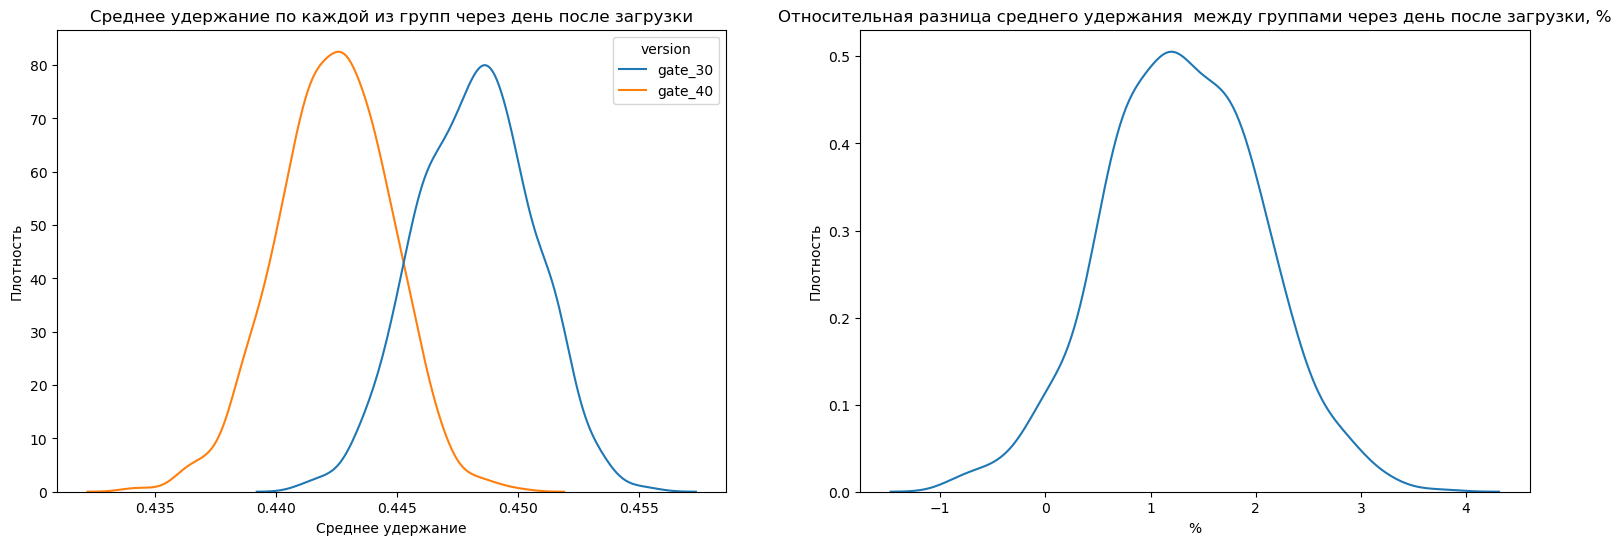


95%-й доверительный интервал относительной разницы среднего удержания через день после загрузки между группами "gate_30" и "gate_40" [-0.15; 2.75]


In [34]:
boot_stat(data, 'retention_1')

#### Распределение среднего удержания через день после загрузки на выборке пользователей, прошедших 30 и более уровней

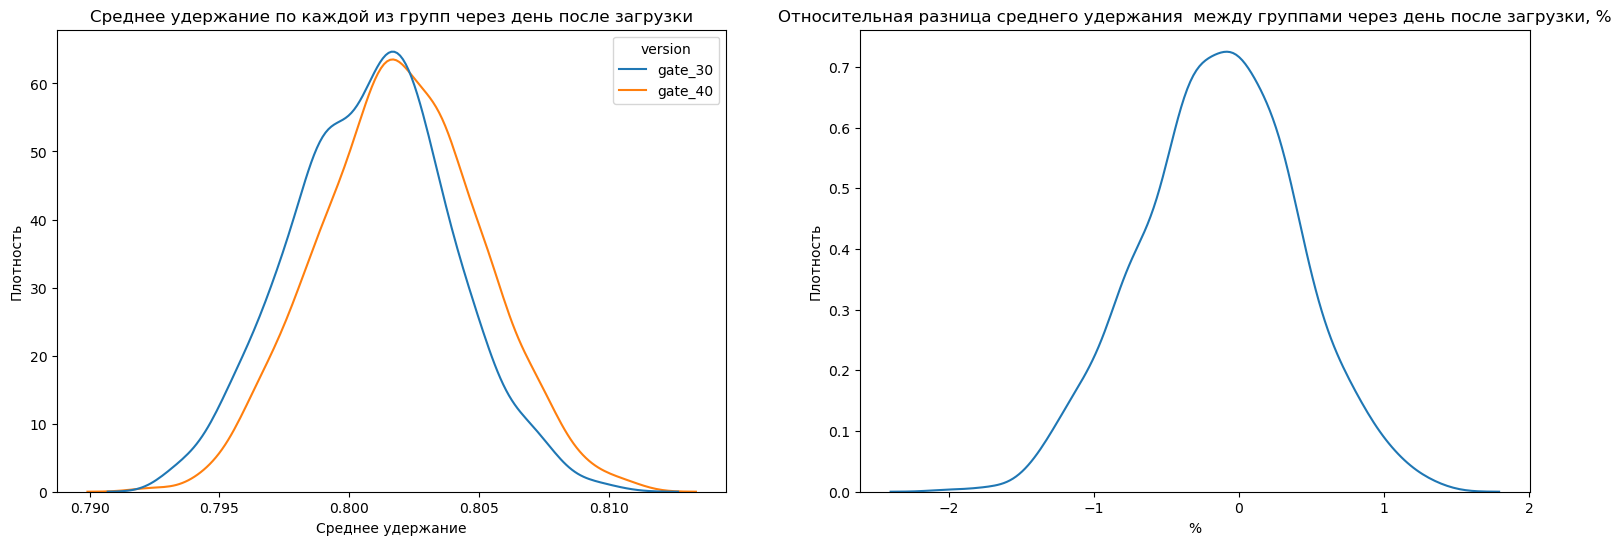


95%-й доверительный интервал относительной разницы среднего удержания через день после загрузки между группами "gate_30" и "gate_40" [-1.19; 0.91]


In [35]:
boot_stat(data_30, 'retention_1')

#### Распределение среднего удержания через день после загрузки на выборке пользователей, прошедших менее 30  уровней

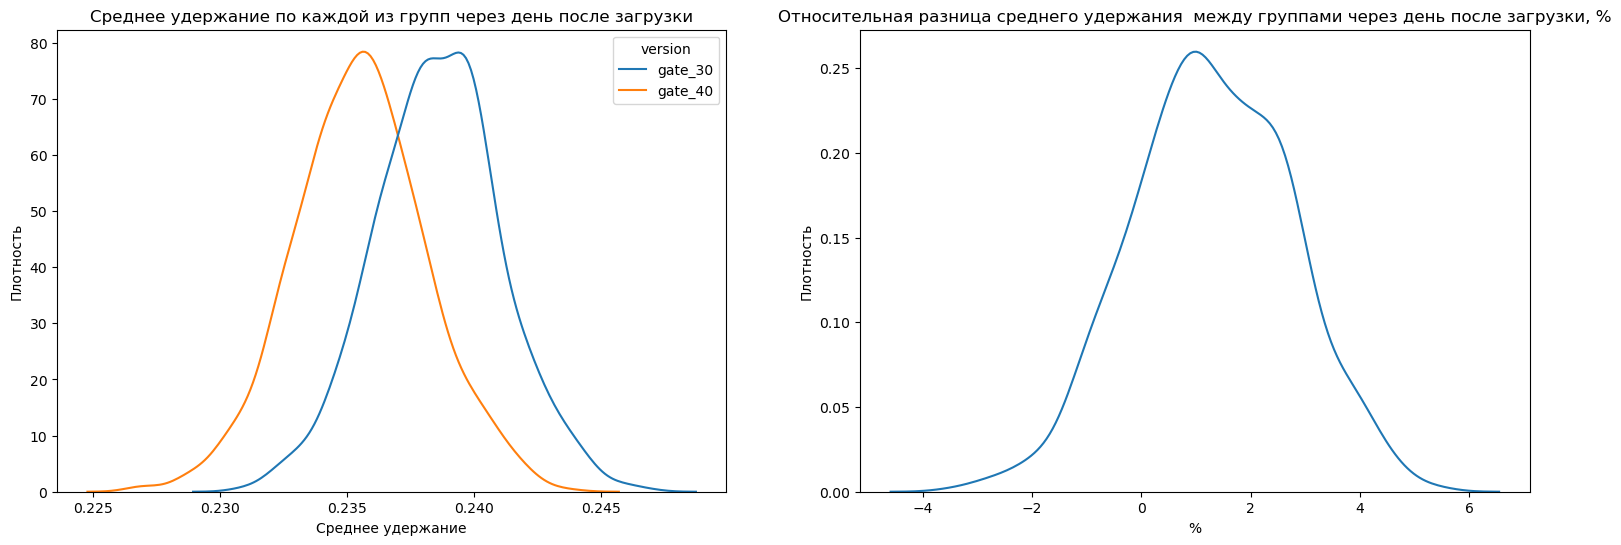


95%-й доверительный интервал относительной разницы среднего удержания через день после загрузки между группами "gate_30" и "gate_40" [-1.58; 4.14]


In [36]:
boot_stat(data_not30, 'retention_1')

#### Вывод: 
Вероятностное распределение удержания через один день после загрузки показало, что в выборке пользователей, прошедших более 30 уровней, существенной разницы между группами не отмечается.
В целом по фрейму и по выборке пользователей, не прошедших 30 уровней, среднее значение удержания через один день после загрузки у контрольной группы  выше относительно тестовой, однако нулевая относительная разница входит в доверительный интервал, что не позволяет отклонить нулевую гиппотезу о равенстве удержания между группами. 

### Распределение среднего удержания через семь дней после загрузки

#### Распределение среднего удержания через семь дней после загрузки по исходным данным

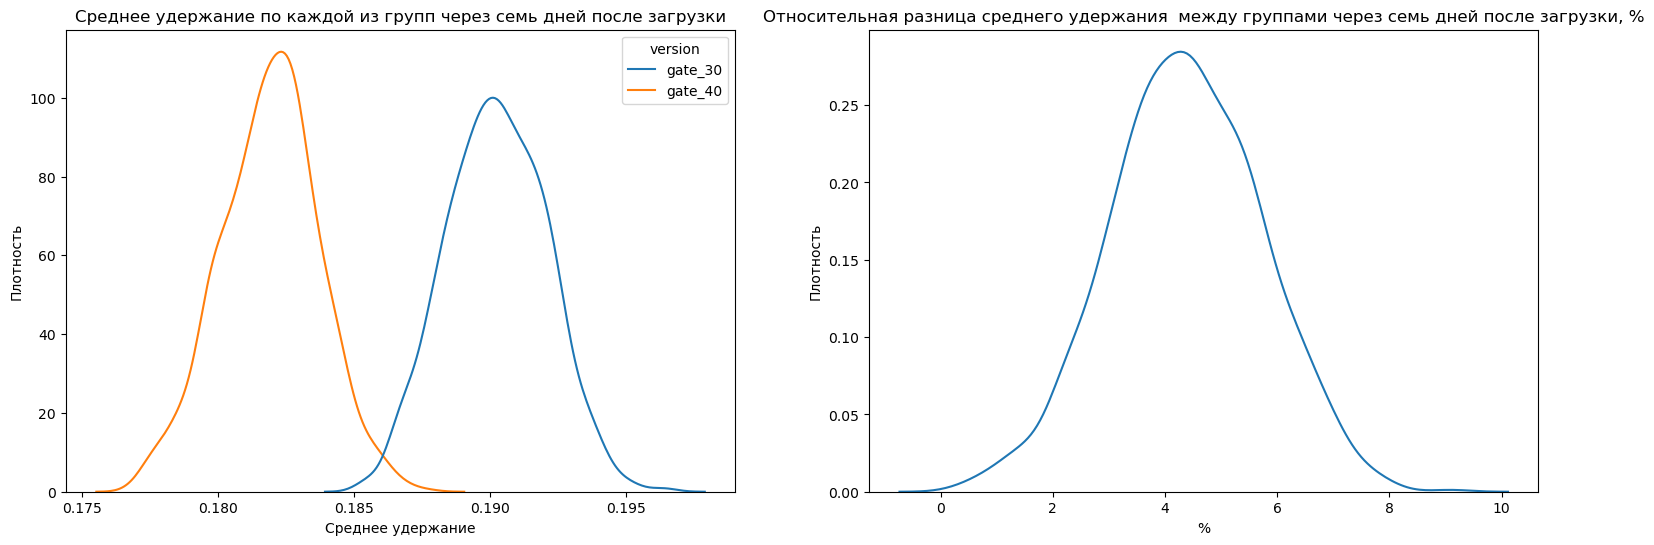


95%-й доверительный интервал относительной разницы среднего удержания через семь дней после загрузки между группами "gate_30" и "gate_40" [1.73; 7.02]


In [37]:
boot_stat(data, 'retention_7')

#### Распределение среднего удержания через семь дней после загрузки на выборке пользователей, прошедших 30 и более уровней

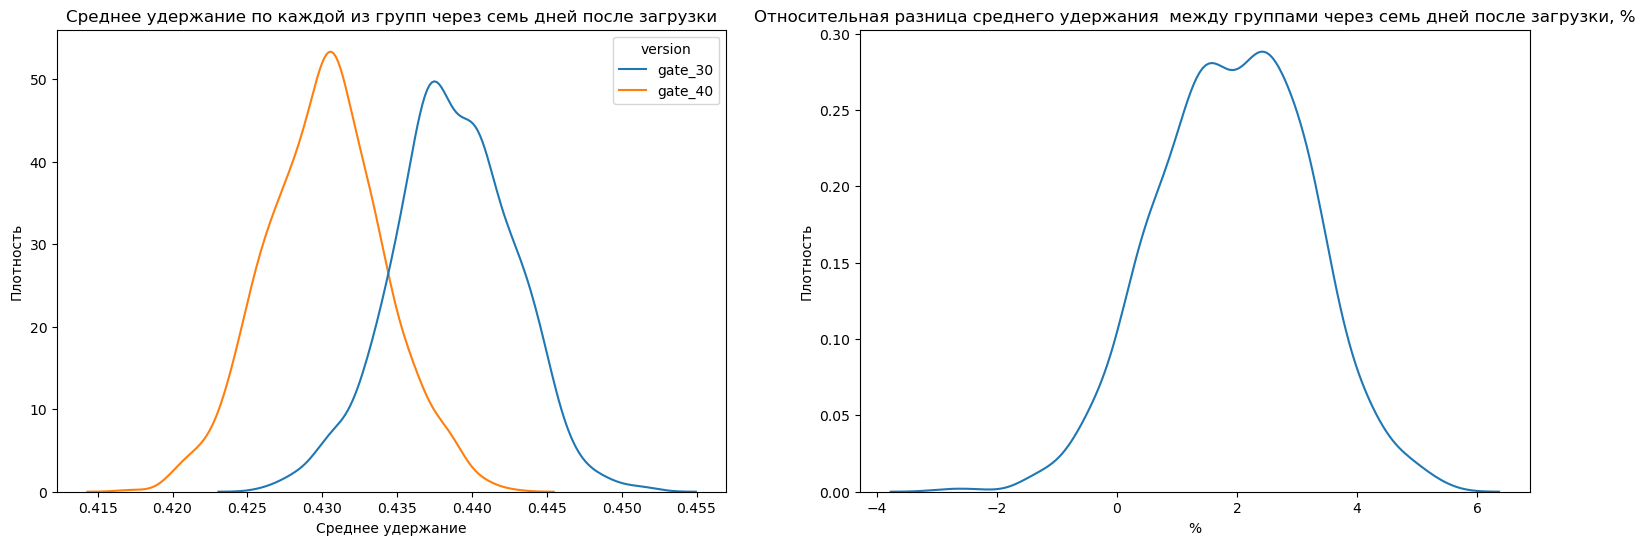


95%-й доверительный интервал относительной разницы среднего удержания через семь дней после загрузки между группами "gate_30" и "gate_40" [-0.51; 4.39]


In [38]:
boot_stat(data_30, 'retention_7')

#### Распределение среднего удержания через семь дней после загрузки на выборке пользователей, прошедших менее 30  уровней

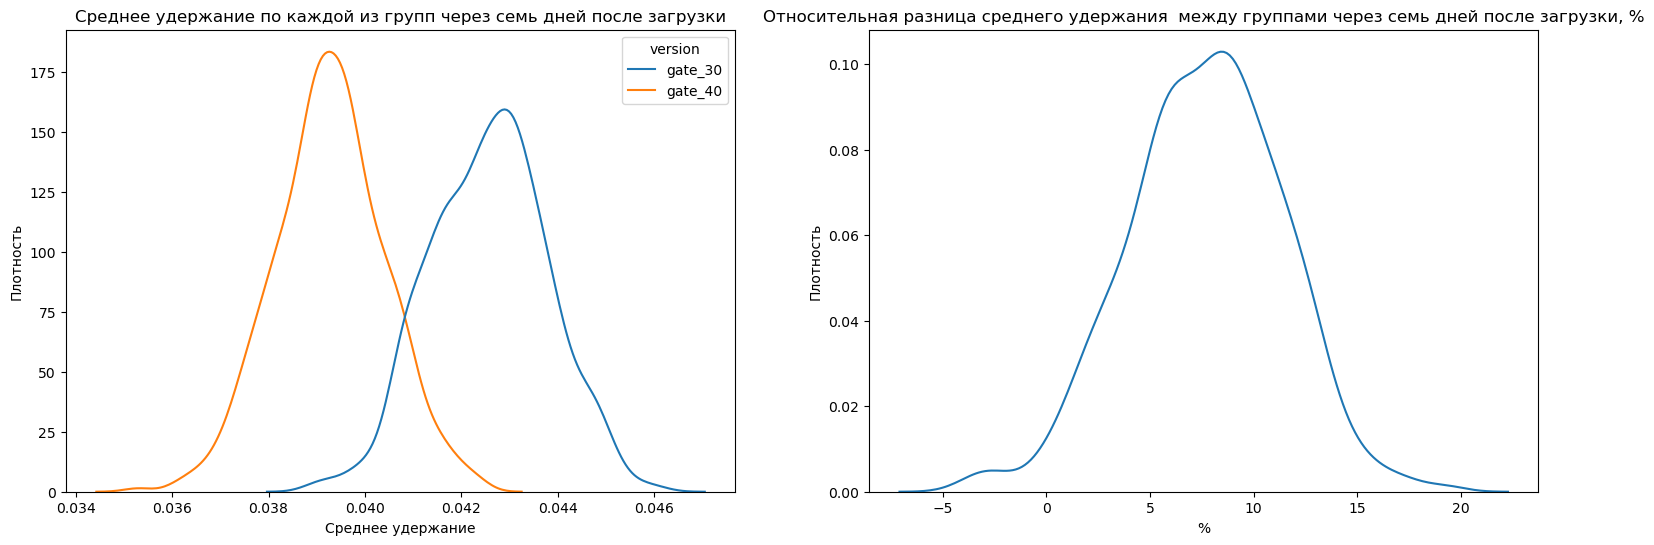


95%-й доверительный интервал относительной разницы среднего удержания через семь дней после загрузки между группами "gate_30" и "gate_40" [0.35; 15.00]


In [39]:
boot_stat(data_not30, 'retention_7')

#### Вывод: 
Вероятностное распределение удержания через семь дней после загрузки по всем выборкам показало, что значение удержания по контрольной группе в целом больше удержания в тестовой группе.
Однако, в выборке пользователей, прошедших 30 и более уровней нулевое значение относительной разницы в удержании входит в 95% доверительный интервал, что не позволяет отклонить гипотезу о равенстве удержания между группами.
В целом по фрейму и по выборке пользователей, не прошедших 30 уровней, нулевое значение относительной разницы средних значений удержания через 7 день после загрузки не входит в в 95% доверительный интервал, что позволяет отвергнуть гипотезу о равенстве удержания между контрольной и тестовой группами. 

## Общий вывод:


Анализ результатов А/В - теста показал, что в целом по данным значение удержания у контрольной группы выше, чем у тестовой. При этом проверка статистических гипотез подтвержает различие между группами через семь дней с момента скачивания игры, статистическая проверка гиппотез не позволяет подтвердить различие в удержании через один день после скачивания.

При этом статистическая проверка в выборке пользователей, прошедших 30 и более уровней, статистически значимых различий в удержании пользователей не выявила.

Статистическая проверка гипотез на выборке пользователей, прошедших менее 30 уровней, не смотря на то, что на данных пользователей влияние исследуемого фактора не оказывалось, показала статистически значимые различия между удержанием пользователей через семь дней после скачивания игры. Что позволяет предположить, что на удержание пользователей оказывали влияние прочие факторы, и не совсем корректно проведено распределение пользователей между исследуемыми группами.